This is Hand Written Text Recognition Project. We will be using **IAM data set**.

Link to dataset: [https://fki.tic.heia-fr.ch/databases/iam-handwriting-database]

## **Data Collection**

1.Download the IAM Words dataset ZIP file.

2.Extract the ZIP file.

3.Create necessary directories (data and data/Words).

4.Extract the contents of the tar archive (words.tgz) into the data/Words directory.

5.Move the words.txt file to the data directory.

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

#drive_folder = '/content/drive/My Drive/Colab Notebooks/HandWritten document recognition'

#!wget -q https://git.io/J0fjL -O "{drive_folder}/IAM_Words.zip"
#!unzip -qq "{drive_folder}/IAM_Words.zip" -d "{drive_folder}"
#!mkdir -p "{drive_folder}/data/Words"
#!tar -xf "{drive_folder}/IAM_Words/words.tgz" -C "{drive_folder}/data/Words"
#!mv "{drive_folder}/IAM_Words/words.txt" "{drive_folder}/data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
import editdistance

import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras 
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
words_file_path = "./words.txt"

 **Getting Words from words.txt**

In [8]:
with open(words_file_path, 'r') as file:
    words = file.readlines()

words_list = []

for line in words:
  if line[0]=="#":
    continue
  if line.split(" ")[1] != "err":  # we do not need to deal with errored entries.
    words_list.append(line)

print(len(words_list))
print(words_list[:5])

np.random.shuffle(words_list)


96456
['a01-000u-00-00 ok 154 408 768 27 51 AT A\n', 'a01-000u-00-01 ok 154 507 766 213 48 NN MOVE\n', 'a01-000u-00-02 ok 154 796 764 70 50 TO to\n', 'a01-000u-00-03 ok 154 919 757 166 78 VB stop\n', 'a01-000u-00-04 ok 154 1185 754 126 61 NPT Mr.\n']


In [10]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(test_samples)

print(f"Total data samples: {len(words_list)}")
print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")


Total data samples: 96456
Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


# **Data Input Pipeline**
Our data images are not organized.

We will build our data input pipeline by first preparing the image paths.

In [13]:
base_image_path = "./words"

def get_image_paths_and_labels(samples):
  paths = []
  corrected_samples = []
  for(i,file_line) in enumerate(samples):
    line_split = file_line.strip()
    line_split = line_split.split(" ")
    #each file_line is as "a01-000u-00-03 ok 154 919 757 166 78 VB stop"
    # part1/part1-part2/part1-part2-part3.png

    image_name = line_split[0]
    partI = image_name.split("-")[0]
    partII = image_name.split("-")[1]
    img_path = os.path.join(
        base_image_path, partI , partI + "-" + partII, image_name + ".png"
    )


    if os.path.getsize(img_path):
      paths.append(img_path)
      corrected_samples.append(file_line.split("\n")[0])

  return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)




In [14]:
print(train_img_paths[0:10])
print(train_labels[0:10])

['./words\\e04\\e04-030\\e04-030-04-08.png', './words\\k02\\k02-102\\k02-102-05-03.png', './words\\a01\\a01-082u\\a01-082u-01-04.png', './words\\m01\\m01-000\\m01-000-07-00.png', './words\\g01\\g01-031\\g01-031-07-06.png', './words\\f07\\f07-081b\\f07-081b-01-06.png', './words\\n03\\n03-082\\n03-082-04-03.png', './words\\g06\\g06-018c\\g06-018c-04-05.png', './words\\g06\\g06-011j\\g06-011j-06-06.png', './words\\f04\\f04-024\\f04-024-01-06.png']
['e04-030-04-08 ok 170 1489 1499 120 39 JJ sure', 'k02-102-05-03 ok 182 836 1623 69 52 PP3A he', 'a01-082u-01-04 ok 172 1582 1043 234 88 IN during', 'm01-000-07-00 ok 196 339 1998 75 107 INO of', 'g01-031-07-06 ok 152 1912 2038 167 59 NN booty', 'f07-081b-01-06 ok 168 1366 924 350 88 NN gastronomy', 'n03-082-04-03 ok 165 992 1414 118 135 NN boy', 'g06-018c-04-05 ok 182 1298 1438 96 58 ATI The', 'g06-011j-06-06 ok 182 1222 1785 146 95 CC and', 'f04-024-01-06 ok 183 1104 981 60 70 IN in']


# **Feature Extraction**
Now we will take the actual label word from sample_lables.

In [18]:
# finding the maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
  label = label.split(" ")[-1].strip()
  for char in label:
    characters.add(char)

  max_len = max(max_len, len(label))
  train_labels_cleaned.append(label)

print("Maximum Length:",max_len)
print("Vocab size:",len(characters))

#checking

train_labels_cleaned[:10]


Maximum Length: 21
Vocab size: 78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

**Now cleaning the validation and the test labels as well.**

In [21]:
def clean_labels(labels):
  cleaned_labels = []
  for label in labels:
    label = label.split(" ")[-1].strip()
    cleaned_labels.append(label)

  return cleaned_labels

validation_labels_cleaned= clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

# **Designing a Character vocabulary.**

The label of the data are character which cannot be directly fit to data instead we need to convert this character to integer. So we will be converting the character label to integer using **StringLookup** by tensorflow

In [24]:
print(characters)
print(len(characters))

{"'", 'Z', 'G', 'e', 'b', 'E', 'Q', 't', 'd', '6', 'N', 'X', 'p', '+', '-', 'w', 'g', 'j', 'S', 'u', '8', 'n', '!', 'B', 'P', 'a', 'o', 'M', 'r', '5', 'W', 'O', '3', 'k', 'A', 'h', 'c', 'D', 'i', '0', 'C', 'q', 'V', 'U', 'T', '4', '7', 'v', 'I', 'F', ')', '/', 'R', ',', '?', 'K', '#', 'l', '.', '1', ':', 'J', 'x', 'y', ';', 's', 'L', '*', '2', '"', 'Y', 'z', '&', 'H', '9', 'f', '(', 'm'}
78


In [26]:
AUTOTUNE = tf.data.AUTOTUNE
#TensorFlow will automatically decide the optimal values for characters.

#mapping character to integer
char_to_num = StringLookup(vocabulary = list(characters), mask_token=None)

#mapping integers back to original characters.
num_to_char = StringLookup(vocabulary = char_to_num.get_vocabulary(), mask_token=None, invert = True)

In [28]:
char_to_num.get_vocabulary()

['[UNK]',
 "'",
 'Z',
 'G',
 'e',
 'b',
 'E',
 'Q',
 't',
 'd',
 '6',
 'N',
 'X',
 'p',
 '+',
 '-',
 'w',
 'g',
 'j',
 'S',
 'u',
 '8',
 'n',
 '!',
 'B',
 'P',
 'a',
 'o',
 'M',
 'r',
 '5',
 'W',
 'O',
 '3',
 'k',
 'A',
 'h',
 'c',
 'D',
 'i',
 '0',
 'C',
 'q',
 'V',
 'U',
 'T',
 '4',
 '7',
 'v',
 'I',
 'F',
 ')',
 '/',
 'R',
 ',',
 '?',
 'K',
 '#',
 'l',
 '.',
 '1',
 ':',
 'J',
 'x',
 'y',
 ';',
 's',
 'L',
 '*',
 '2',
 '"',
 'Y',
 'z',
 '&',
 'H',
 '9',
 'f',
 '(',
 'm']

In [30]:
print(char_to_num(tf.constant(["A"])))
#here A got value 76
# the values nott in the characters  list gets value 0

tf.Tensor([35], shape=(1,), dtype=int64)


# **Image Preprocessing**

### **Resizing image using Padding**


Instead of using square images, many OCR models use rectangular images. You'll see why when we look at some examples from the dataset.Resizing square images without keeping their proportions doesn't distort them much, but this isn't true for rectangular images. However, we need to resize images to the same size for mini-batching. So, we must resize them while:

1. Keeping their aspect ratio the same.
2. Ensuring the image content remains unaffected.

In [35]:
def distortion_free_resize(image, img_size):
  w,h = img_size
  image = tf.image.resize(image, size=(h,w),preserve_aspect_ratio=True)  # size paraeter takes height first and then width
  #The resulting image might not be exactly (h,w) pixels but will fit within these dimensions without any distortion.
  # if any pixel left we will use padding

  #checking the padding height and width
  pad_height = h-tf.shape(image)[0]
  pad_width = w-tf.shape(image)[1]

  #Only necessary if you want to do some amount of padding on both sides.
  if pad_height % 2 !=0:
    height=pad_height//2
    pad_height_top = height +1
    pad_height_bottom = height
  else:
    pad_height_top = pad_height_bottom = pad_height // 2

  if pad_width %2 != 0:
    width = pad_width //2
    pad_width_left = width +1
    pad_width_right = width
  else:
    pad_width_left = pad_width_right = pad_width //2

  image = tf.pad(
      image,
      paddings = [
          [pad_height_top, pad_height_bottom],
          [pad_width_left, pad_width_right],
          [0,0],
      ],

  )
  image = tf.transpose(image, perm=[1,0,2])
  image = tf.image.flip_left_right(image)
  # because tf.resize uses (h,w) way
  return image



# **Putting all together**

In [38]:
batch_size = 32
padding_token = 99
image_width = 128
image_height = 32

def preprocessing_image(image_path, img_size=(image_width, image_height)):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image,channels=1) # decode the png_encoded images into tensor , channel 1 for gray scale
  image = distortion_free_resize(image,img_size)
  image = tf.cast(image, tf.float32)/255.0  # data type conversion in tensor
  return image

def vectorize_label(label):
  label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
  length = tf.shape(label)[0]
  pad_amount = max_len-length
  label = tf.pad(label, paddings=[[0,pad_amount]], constant_values = padding_token)
  return label

def decode_label(encoded_label):
    unpadded_label = tf.boolean_mask(encoded_label, encoded_label != padding_token)
    decoded_word = num_to_char(unpadded_label)
    return tf.strings.reduce_join(decoded_word).numpy().decode("utf-8")

def process_images_labels(image_path, label):
  image = preprocessing_image(image_path)
  label = vectorize_label(label)
  return {"image":image, "label":label}

def prepare_dataset(image_paths, labels):
  dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(process_images_labels, num_parallel_calls=AUTOTUNE)
  return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)



**Preparing tf.data.Dataset objects**

In [41]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)


### **Visualizing a few Samples**

In [44]:
print(train_ds)

<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>


In [46]:
train_ds_iter = iter(train_ds)
batch = next(train_ds_iter)
image_tensor = batch['image']
print("Image tensor details:")
print(f"Shape: {image_tensor.shape}")
print(f"Dtype: {image_tensor.dtype}")
print(f"Example data: {image_tensor.numpy()[0][20]}")  # Print the first image in the batch

label_tensor = batch['label']
print("Label tensor details:")
print(f"Shape: {label_tensor.shape}")
print(f"Dtype: {label_tensor.dtype}")
print(f"Example data: {label_tensor.numpy()[0]}")  # Print the first label in the batch

Image tensor details:
Shape: (32, 128, 32, 1)
Dtype: <dtype: 'float32'>
Example data: [[0.7879308 ]
 [0.41669166]
 [0.33433872]
 [0.5890069 ]
 [0.9208927 ]
 [0.97726715]
 [0.9816583 ]
 [0.9833934 ]
 [0.9833934 ]
 [0.9810781 ]
 [0.97783613]
 [0.97730905]
 [0.9812506 ]
 [0.9661871 ]
 [0.9751751 ]
 [0.9833934 ]
 [0.9839542 ]
 [0.9843137 ]
 [0.9832958 ]
 [0.9818653 ]
 [0.98383915]
 [0.9843137 ]
 [0.98346525]
 [0.98346967]
 [0.97938985]
 [0.9790454 ]
 [0.98290753]
 [0.9843137 ]
 [0.9838823 ]
 [0.98247296]
 [0.9837097 ]
 [0.9843137 ]]
Label tensor details:
Shape: (32, 21)
Dtype: <dtype: 'int64'>
Example data: [66 20 29  4 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]


# **Model**

We will be using **CTC(Connectionist Temporal Classification)**  loss as an endpoint layer.CTC is a neural network output layer designed to solve sequence-to-sequence problems where the alignment between input and output sequences is unknown.

**CNNs** (for spatial feature extraction) and **RNNs **(for sequential modeling).

In [50]:
class CTCLayer(keras.layers.Layer):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.loss_fn = keras.backend.ctc_batch_cost

  def call(self,y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[0], dtype = "int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len,1), dtype="int64")
    loss = self.loss_fn(y_true, y_pred, input_length, label_length)
    self.add_loss(loss)

    return y_pred

def build_model():
  # Inputs to the model. These are used when the input and output have different structures.
  input_img = keras.Input(shape=(image_width, image_height,1), name = "image")
  labels = keras.layers.Input(name="label", shape=(None,))

  # first conv block.
  x = keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1")(input_img)
  x = keras.layers.MaxPooling2D((2,2), name="pool1")(x)

  #Second conv block.
  x = keras.layers.Conv2D(64, (3,3), activation = "relu", kernel_initializer="he_normal", padding="same",name="Conv2")(x)
  x = keras.layers.MaxPooling2D((2,2), name = "pool2")(x)

  # Here we have used two max pool with pool size and strides 2.
  # Hence, downsampled feature maps are 4x smaller.
  # The number of filter in the last layer is 64 .
  # Reshape accordingly before passing the output to the RNN part of the model.

  #If the CNN output is of shape (batch_size, new_width, new_height, num_channels), the reshaping converts it to (batch_size, new_width, new_height * num_channels).
  #This is necessary to convert the output of the CNN into a format suitable for the subsequent Dense layer and RNN.
  #primary purpose of Dropout is to prevent overfitting and generalize during the training of the neural network.
  new_shape = ((image_width // 4), (image_height // 4)* 64)
  x = keras.layers.Reshape(target_shape = new_shape, name="reshape")(x)
  x = keras.layers.Dense(64, activation= "relu", name="dense1")(x)
  x = keras.layers.Dropout(0.2)(x)

  #RNNs
  x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout = 0.25))(x)
  x = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences = True, dropout = 0.25))(x)

  # +2 is to account for the two special tokens introduced by the CTC loss.
  # The recommendation is from https://git.io/J0eXP.
  x = keras.layers.Dense(len(char_to_num.get_vocabulary()) + 2, activation = "softmax", name="dense2")(x)

  #Add CTC layer for calculating CTC loss at each step.
  output = CTCLayer(name="ctc_loss")(labels, x)

  #Define the model.
  model = keras.models.Model(
      inputs = [input_img, labels], outputs = output, name="handwriting_recognizer")
  #optimizer
  opt = keras.optimizers.Adam()
  #compile the model and return
  model.compile(optimizer = opt)
  return model


#Get model
model = build_model()
model.summary()


Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

# **Edit Distance as Evaluation Metrix**
Edit distance is the most widely used matric for evaluating OCR models. It is also known as Levenshtein distance, is a metric for evaluating the similarity between two sequences by counting the minimum number of operations required to transform one sequence into the other.




In [52]:
# we first segregate the validation images and their labels for convenience.
with tf.device('/GPU:0'):
  validation_images = []
  validation_labels = []

  for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])


In [53]:
# Now, we create a callback to monitor the edit distances.


def calculate_edit_distance(labels, predictions):
  #converting the labels into a sparse tensors.
  saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

  input_len = np.ones(predictions.shape[0])*predictions.shape[1]
  predictions_decoded = keras.backend.ctc_decode(predictions, input_length=input_len, greedy = True)[0][0][:,:max_len]
  sparse_predictions = tf.cast(tf.sparse.from_dense(predictions_decoded),dtype=tf.int64)

  # compute individual edit distance and average them out.
  edit_distances = tf.edit_distance(
      sparse_predictions, saprse_labels, normalize=False
  )
  return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
  def __init__(self, pred_model):
    super().__init__()
    self.prediction_model = pred_model

  def on_epoch_end(self, epoch, logs=None):
    edit_distance = []

    for i in range(len(validation_images)):
      lables = validation_labels[i]
      predictions = self.prediction_model.predict(validation_images[i])
      edit_distance.append(calculate_edit_distance(labels, predictions).numpy())
    print(
        f"Mean edit distance for epoch {epoch+1}: {np.mean(edit_distance):.4f}"
    )

# **Character Error Rate as Evaluation Metrix**

In [55]:
def decode_batch_prediction(pred):
  input_len = np.ones(pred.shape[0])*pred.shape[1]

  # Use greedy search For complex tasks , you can use beam search.
  results = keras.backend.ctc_decode(pred, input_length=input_len, greedy = True )[0][0][:,:max_len]
  #Iterate over the results and get back the text.
  output_text = []
  for res in results:
    res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
    res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
    output_text.append(res)
  return output_text

def calculate_character_error_rate(gt, pred):
    total_errors = 0
    total_characters = 0
    for word_gt, word_pred in zip(gt, pred):
        # Compute the edit distance for each word
        distance = editdistance.eval(word_gt, word_pred)
        total_errors += distance
        total_characters += len(word_gt)
    # Calculate CER
    return total_errors / total_characters


In [56]:
class CharacterErrorRateCallback(keras.callbacks.Callback):
    def __init__(self, prediction_model):
        super().__init__()
        self.prediction_model = prediction_model
        self.cer_per_epoch = []  

    def on_epoch_end(self, epoch, logs=None):
        label_words = []
        predicted_words = []
        for batch in test_ds.take(2):
            batch_images = batch["image"]
            batch_labels = batch["label"]

            for word in batch_labels:
                label_words.append(decode_label(word))
            preds = self.prediction_model.predict(batch_images)
            predi_word = decode_batch_prediction(preds)
            predicted_words.append(predi_word)

        predict_words = [item for sublist in predicted_words for item in sublist]
        CERs = calculate_character_error_rate(label_words, predict_words)
        self.cer_per_epoch.append(f"{CERs:.4f}")

        print(
            f"Epoch {epoch + 1}: Mean CER = {np.mean(CERs):.4f}"
        )


# **Training the Model**

In [64]:
with tf.device('/GPU:0'):
    epochs = 70
    
    model = build_model()
    input_layer = model.inputs[0]
    print(input_layer)
    output_layer = model.get_layer(name="dense2").output
    print(output_layer)
    prediction_model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    print(prediction_model)
    
    CER_callback = CharacterErrorRateCallback(prediction_model)
    # Train the model
    history = model.fit(
        train_ds,
        validation_data = validation_ds,
        epochs = epochs,
        callbacks=[CER_callback]
    )

KerasTensor(type_spec=TensorSpec(shape=(None, 128, 32, 1), dtype=tf.float32, name='image'), name='image', description="created by layer 'image'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 81), dtype=tf.float32, name=None), name='dense2/Softmax:0', description="created by layer 'dense2'")
Epoch 1/70
1/1 [==============================] - 0s 44ms/step
Epoch 1: Mean CER = 0.7808
2713/2713 [==============================] - 934s 343ms/step - loss: 12.7358 - val_loss: 10.6116
Epoch 2/70
1/1 [==============================] - 0s 42ms/step
Epoch 2: Mean CER = 0.5346
2713/2713 [==============================] - 131s 48ms/step - loss: 9.4323 - val_loss: 7.7815
Epoch 3/70
1/1 [==============================] - 0s 26ms/step
Epoch 3: Mean CER = 0.3923
2713/2713 [==============================] - 128s 47ms/step - loss: 7.0261 - val_loss: 5.5080
Epoch 4/70
1/1 [==============================] - 0s 33ms/step
Epoch 4: Mean CER = 0.3308
2713/2713 [==============================] - 137s 50ms/ste

# **CER and WER plot**

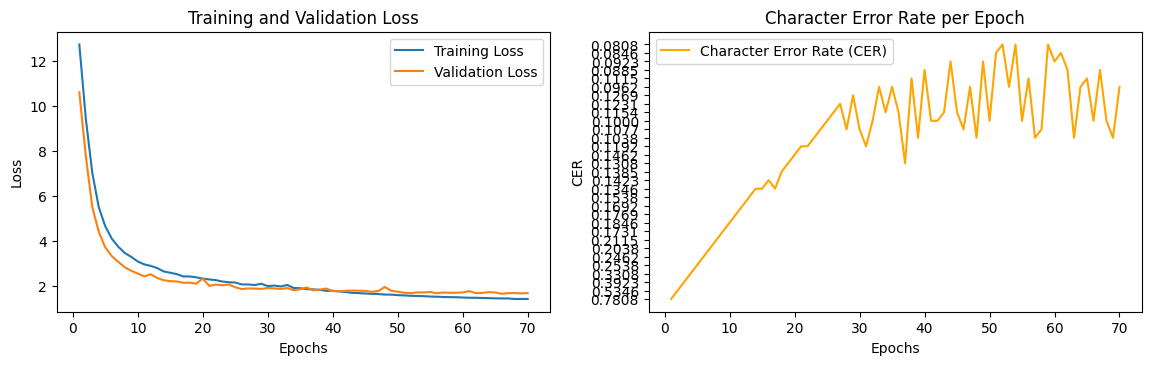

In [70]:
# Plot Training and Validation Loss
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(14, 8))

# Training and Validation Loss
plt.subplot(2, 2, 1)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Character Error Rate (CER)
plt.subplot(2, 2, 2)
plt.plot(epochs_range, CER_callback.cer_per_epoch, label='Character Error Rate (CER)', color='orange')
plt.xlabel('Epochs')
plt.ylabel('CER')
plt.title('Character Error Rate per Epoch')
plt.legend()

In [74]:
prediction_model.save('model_V80.keras')
prediction_model.save('model_V80.h5')

In [72]:
label_words = []
predicted_words = []
for batch in test_ds:
    batch_images = batch["image"]
    batch_labels = batch["label"]

    for word in batch_labels:
        label_words.append(decode_label(word))
    preds = prediction_model.predict(batch_images)
    predi_word = decode_batch_prediction(preds)
    predicted_words.append(predi_word)

predict_words = [item for sublist in predicted_words for item in sublist]
CERs = calculate_character_error_rate(label_words, predict_words)
print("The CER for train dataset be : ", CERs)

1/1 [==============================] - 3s 3s/step
The CER for train dataset be :  0.1094


1/1 [==============================] - 1s 1s/step
Predicted Text: smmm[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]


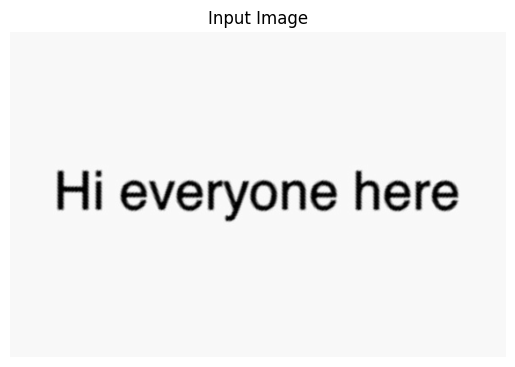

In [82]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2  # OpenCV for image processing

# Load the trained model
model_path = 'model_V80.h5'  # Update this with your model's path
model = keras.models.load_model(model_path, custom_objects={'CTCLayer': CTCLayer})

# Function to preprocess the image
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = distortion_free_resize(image, (image_width, image_height))  # Ensure this function is defined
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Function to decode predicted labels
def decode_prediction(encoded_label):
    unpadded_label = tf.boolean_mask(encoded_label, encoded_label != padding_token)
    decoded_word = num_to_char(unpadded_label)  # Ensure this function is defined
    return tf.strings.reduce_join(decoded_word).numpy().decode("utf-8")

# Function to predict text from an image
def predict_text(image_path):
    # Preprocess the image
    preprocessed_image = preprocess_image(image_path)
    preprocessed_image = tf.expand_dims(preprocessed_image, axis=0)  # Add batch dimension

    # Make predictions (only use the preprocessed image)
    predictions = model.predict(preprocessed_image)
    
    # Decode the predictions
    predicted_label = keras.backend.ctc_decode(predictions, input_length=np.ones(predictions.shape[0]) * predictions.shape[1], greedy=True)[0][0]

    # Decode the prediction to text
    text = decode_prediction(predicted_label)
    return text

# Example usage
image_path = 'x.jpg'  # Update this with the path to your image
predicted_text = predict_text(image_path)

print("Predicted Text:", predicted_text)

# Optional: Visualize the input image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
plt.title("Input Image")
plt.axis('off')
plt.show()
